# LSB

In [68]:
import cv2
import numpy as np

def lsb_embed(image_path, watermark_bits, output_path):
    img = cv2.imread(image_path)
    flat = img.flatten()

    for i, bit in enumerate(watermark_bits):
        flat[i] = (flat[i] & 254) | bit

    watermarked = flat.reshape(img.shape)
    cv2.imwrite(output_path, watermarked)

In [69]:
def lsb_detect(image_path, watermark_bits):
    img = cv2.imread(image_path)
    flat = img.flatten()

    extracted = [flat[i] & 1 for i in range(len(watermark_bits))]
    return extracted == watermark_bits

In [70]:
watermark = [1,0,1,1,0,1,0,1]

lsb_embed("image2.png", watermark, "lsb.png")
print(lsb_detect("image2.png", watermark)) 
print(lsb_detect("lsb.png", watermark)) 

False
True


# DCT

In [6]:
from scipy.fftpack import dct, idct

def dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def idct2(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

def dct_embed(image_path, output_path):
    img = cv2.imread(image_path, 0)
    img = img.astype(float)

    block = img[:8, :8]
    dct_block = dct2(block)

    dct_block[4, 4] += 50
    img[:8, :8] = idct2(dct_block)

    cv2.imwrite(output_path, np.clip(img, 0, 255))

In [72]:
def dct_detect(image_path):
    img = cv2.imread(image_path, 0).astype(float)
    block = img[:8, :8]
    dct_block = dct2(block)

    return dct_block[4, 4] > 20

In [73]:
dct_embed("image1.jpg", "dct.jpg")
print(dct_detect("image1.jpg"))
print(dct_detect("dct.jpg"))

False
True


# DWT

In [5]:
import pywt

def dwt_embed(image_path, output_path):
    img = cv2.imread(image_path, 0)
    coeffs = pywt.dwt2(img, 'haar')

    LL, (LH, HL, HH) = coeffs
    HH += 10

    watermarked = pywt.idwt2((LL, (LH, HL, HH)), 'haar')
    cv2.imwrite(output_path, np.uint8(watermarked))

In [75]:
def dwt_detect(image_path):
    img = cv2.imread(image_path, 0)
    coeffs = pywt.dwt2(img, 'haar')
    _, (_, _, HH) = coeffs

    return np.mean(HH) > 5

In [76]:
dwt_embed("image1.jpg", "dwt.jpg")
print(dwt_detect("image1.jpg"))
print(dwt_detect("dwt.jpg"))

False
True


# imwatermark

In [4]:
from imwatermark import WatermarkEncoder

img = cv2.imread("image1.jpg")

wm = np.array([1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0], dtype=np.uint8)

encoder = WatermarkEncoder()
encoder.set_watermark('bits', wm)

encoded = encoder.encode(img, 'dwtDct')
cv2.imwrite("watermarked_bits.jpg", encoded)


NameError: name 'cv2' is not defined

In [94]:
from imwatermark import WatermarkDecoder

decoder = WatermarkDecoder('bits', 12)
decoded = decoder.decode(encoded, 'dwtDct')

print("Decoded bits:", decoded)


Decoded bits: [ True  True  True  True False  True  True False  True  True False  True]


# image-invisible-watermarker

In [3]:
from image_watermarker import add_watermark_png, check_watermark_png

image_bytes = add_watermark_png("image2.png", "My Watermark")
if image_bytes:
    with open("output.png", "wb") as f:
        f.write(image_bytes)

result1 = check_watermark_png("image2.png", "My Watermark")
result2 = check_watermark_png("output.png", "My Watermark")
print("IsDetected:", result1[0])
print("IsDetected:", result2[0])
print("Detected Text:", result2[1])

IsDetected: False
IsDetected: True
Detected Text: My Watermark


# GAN

In [78]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm


In [79]:
class WatermarkEncoder(nn.Module):
    def __init__(self, watermark_len=32):
        super().__init__()
        self.wm_fc = nn.Linear(watermark_len, 64 * 64)

        self.conv = nn.Sequential(
            nn.Conv2d(4, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, 1)
        )

    def forward(self, image, watermark):
        B, C, H, W = image.shape
        wm_map = self.wm_fc(watermark).view(B, 1, H, W)
        x = torch.cat([image, wm_map], dim=1)
        return torch.sigmoid(self.conv(x))

In [80]:
class WatermarkDecoder(nn.Module):
    def __init__(self, watermark_len=32):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.fc = nn.Linear(128, watermark_len)

    def forward(self, image):
        x = self.features(image)
        x = x.view(x.size(0), -1)
        return torch.sigmoid(self.fc(x))

In [81]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x)


In [82]:
device = "cuda" if torch.cuda.is_available() else "cpu"
watermark_len = 32
batch_size = 32
epochs = 30

In [83]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

dataset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [84]:
encoder = WatermarkEncoder(watermark_len).to(device)
decoder = WatermarkDecoder(watermark_len).to(device)

opt = torch.optim.Adam(
    list(encoder.parameters()) + list(decoder.parameters()),
    lr=1e-3
)

bce = torch.nn.BCELoss()
mse = torch.nn.MSELoss()


In [85]:
for epoch in range(epochs):
    for images, _ in tqdm(loader):
        images = images.to(device)

        watermark = torch.randint(
            0, 2, (images.size(0), watermark_len),
            device=device
        ).float()

        watermarked = encoder(images, watermark)

        decoded = decoder(watermarked)

        image_loss = mse(watermarked, images)
        watermark_loss = bce(decoded, watermark)

        loss = image_loss + watermark_loss * 5

        opt.zero_grad()
        loss.backward()
        opt.step()

    print(f"Epoch {epoch} | Loss: {loss.item():.4f}")


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:14<00:00, 105.24it/s]


Epoch 0 | Loss: 3.1360


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:14<00:00, 109.14it/s]


Epoch 1 | Loss: 2.1873


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:14<00:00, 108.95it/s]


Epoch 2 | Loss: 1.5135


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:14<00:00, 109.00it/s]


Epoch 3 | Loss: 1.2165


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:14<00:00, 107.97it/s]


Epoch 4 | Loss: 0.8166


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:14<00:00, 109.07it/s]


Epoch 5 | Loss: 1.3002


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:14<00:00, 107.19it/s]


Epoch 6 | Loss: 0.8277


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:14<00:00, 106.70it/s]


Epoch 7 | Loss: 0.8509


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:14<00:00, 108.39it/s]


Epoch 8 | Loss: 0.7214


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:14<00:00, 108.70it/s]


Epoch 9 | Loss: 0.7253


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:14<00:00, 107.92it/s]


Epoch 10 | Loss: 0.6563


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:14<00:00, 108.18it/s]


Epoch 11 | Loss: 0.7365


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:14<00:00, 107.90it/s]


Epoch 12 | Loss: 0.6446


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:14<00:00, 107.78it/s]


Epoch 13 | Loss: 0.6222


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:14<00:00, 107.24it/s]


Epoch 14 | Loss: 0.7847


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:14<00:00, 106.85it/s]


Epoch 15 | Loss: 0.6840


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:14<00:00, 107.70it/s]


Epoch 16 | Loss: 0.6215


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:14<00:00, 107.55it/s]


Epoch 17 | Loss: 0.7195


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:14<00:00, 107.46it/s]


Epoch 18 | Loss: 0.7028


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:14<00:00, 107.90it/s]


Epoch 19 | Loss: 0.7772


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:14<00:00, 106.81it/s]


Epoch 20 | Loss: 0.7596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:14<00:00, 107.24it/s]


Epoch 21 | Loss: 0.5067


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:14<00:00, 107.46it/s]


Epoch 22 | Loss: 0.7956


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:14<00:00, 107.58it/s]


Epoch 23 | Loss: 0.6597


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:14<00:00, 107.49it/s]


Epoch 24 | Loss: 0.5892


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:14<00:00, 107.86it/s]


Epoch 25 | Loss: 0.5412


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:14<00:00, 108.84it/s]


Epoch 26 | Loss: 0.5682


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:14<00:00, 108.41it/s]


Epoch 27 | Loss: 0.4595


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:14<00:00, 107.54it/s]


Epoch 28 | Loss: 0.7158


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:14<00:00, 107.92it/s]

Epoch 29 | Loss: 0.3951


In [86]:
with torch.no_grad():
    decoded = decoder(watermarked)
    detected = (decoded > 0.5).float()

bit_accuracy = (detected == watermark).float().mean().item()
print(f"Watermark bit accuracy: {bit_accuracy * 100:.2f}%")


Watermark bit accuracy: 96.48%


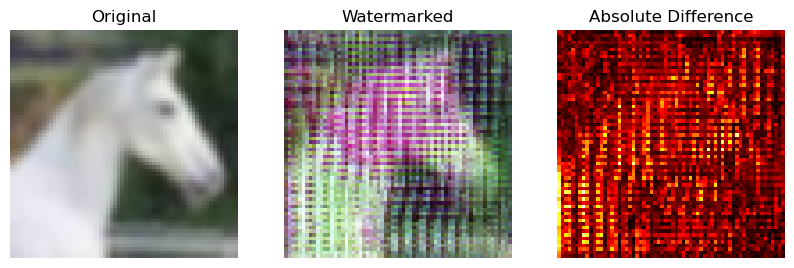

In [87]:
import matplotlib.pyplot as plt

encoder.eval()
decoder.eval()

images, _ = next(iter(loader))
images = images.to(device)

watermark = torch.randint(
    0, 2, (images.size(0), watermark_len),
    device=device
).float()

with torch.no_grad():
    watermarked = encoder(images, watermark)
    decoded = decoder(watermarked)

def show_images(orig, wm, idx=0):
    fig, axs = plt.subplots(1, 3, figsize=(10, 3))

    axs[0].imshow(orig[idx].permute(1, 2, 0).cpu())
    axs[0].set_title("Original")
    axs[0].axis("off")

    axs[1].imshow(wm[idx].permute(1, 2, 0).cpu())
    axs[1].set_title("Watermarked")
    axs[1].axis("off")

    diff = (wm[idx] - orig[idx]).abs().mean(0)
    axs[2].imshow(diff.cpu(), cmap="hot")
    axs[2].set_title("Absolute Difference")
    axs[2].axis("off")

    plt.show()

show_images(images, watermarked, idx=0)

In [88]:
class WatermarkDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)


In [89]:
from torch.utils.data import random_split

dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

train_ds, test_ds = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


In [90]:
def make_detector_batch(images):
    images = images.to(device)
    watermark = torch.randint(
        0, 2, (images.size(0), watermark_len),
        device=device
    ).float()

    with torch.no_grad():
        watermarked = encoder(images, watermark)

    X = torch.cat([images, watermarked], dim=0)
    y = torch.cat([
        torch.zeros(images.size(0)),
        torch.ones(images.size(0))
    ]).to(device)

    return X, y


In [91]:
detector = WatermarkDetector().to(device)
opt_d = torch.optim.Adam(detector.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

for epoch in range(3):
    detector.train()
    total_acc = 0
    n = 0

    for images, _ in train_loader:
        X, y = make_detector_batch(images)

        logits = detector(X).squeeze()
        loss = criterion(logits, y)

        opt_d.zero_grad()
        loss.backward()
        opt_d.step()

        preds = (torch.sigmoid(logits) > 0.5).float()
        total_acc += (preds == y).sum().item()
        n += y.numel()

    print(f"Epoch {epoch} | Train acc: {100*total_acc/n:.2f}%")


Epoch 0 | Train acc: 99.53%
Epoch 1 | Train acc: 100.00%
Epoch 2 | Train acc: 100.00%


In [92]:
detector.eval()
total_acc = 0
n = 0

with torch.no_grad():
    for images, _ in test_loader:
        X, y = make_detector_batch(images)

        logits = detector(X).squeeze()
        preds = (torch.sigmoid(logits) > 0.5).float()

        total_acc += (preds == y).sum().item()
        n += y.numel()

print(f"TEST accuracy: {100*total_acc/n:.2f}%")


TEST accuracy: 100.00%
